### Add support for dropout in the fully-connected layers
    The dropout is added in the fully-connected layer in CustomModel, the probability is set in the argument of the function.

### Add support for GeM pooling
    The GeM pooling is used in the CustomModel after the backbone, its implementation is taken from github repo website: https://amaarora.github.io/posts/2020-08-30-gempool.html.

In [1]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoModel, AutoTokenizer, get_cosine_schedule_with_warmup
from datasets import load_dataset
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torchvision


class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, train=True):
        self.image_paths = df["image_id"]
        if train:
            self.labels = df["label"]
        else:
            self.labels = None
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_paths.iloc[idx])
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        if self.labels is not None:
            label = self.labels.iloc[idx]
            label = torch.tensor(label_mapping[label], dtype=torch.long)
            return img, label
        else:
            return img, torch.zeros(img.shape)


class CustomModel(nn.Module):
    def __init__(self, backbone, num_classes=6, dropout_prob=0.3, model_type="cnn"):
        super(CustomModel, self).__init__()
        
        self.backbone = backbone
        self.model_type = model_type
        
        in_features = self.backbone.num_features
        self.pooling = GeM()

        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        if self.model_type == "cnn":
            x = self.backbone.forward_features(x)
            x = self.pooling(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        elif self.model_type == "swin":
            x = self.backbone.forward_features(x)
            x = x.permute(0, 3, 1, 2)
            x = self.pooling(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        elif self.model_type == "vit":
            x = self.backbone.forward_features(x)
            x = x[:, 0, :] # CLS pooling
            x = self.fc(x)

        return x


# taken from: https://amaarora.github.io/posts/2020-08-30-gempool.html
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

### Add support for test time augmentations
    The test time augmentation is defined in function tta_inference, which can be used instead of inference_loop based on the apply_tta parameter in the validation_loop or in the predict function for testing.

In [2]:
import torchvision.transforms as T
from torchvision.transforms import Compose, Normalize, RandomErasing, Pad
from torchvision.transforms.v2 import CutMix, MixUp

cutmix = CutMix(num_classes=6, alpha=1.0)
mixup = MixUp(num_classes=6, alpha=1.0) 

def tta_inference(model, dataloader, device, loss_fn=None, only_horizontal=True, normalize=None, normalize_input=False):
    predictions = []
    labels = []
    total_loss = 0.0
    total_samples = 0

    model.to(device)
    model.eval()
    pbar = tqdm(dataloader, desc="TTA_Inference")

    with torch.no_grad():
        for images, l in pbar:
            images, l = images.to(device), l.to(device)
            batch_preds = []
            if only_horizontal:
                horizontal_transform = Compose([T.RandomHorizontalFlip(p=1)])
                augmented_images = torch.stack([horizontal_transform(img.cpu()) for img in images]).to(device)
                # augmented images
                pred = model(augmented_images)
                batch_preds.append(pred)

                # original images
                pred = model(images)
                batch_preds.append(pred)
            else:
                TTA_augmentations = [T.RandomHorizontalFlip(p=1),
                                     T.RandomVerticalFlip(p=1),
                                     T.RandomRotation(15)]
                for i in range(3):
                    tta_transform = Compose([TTA_augmentations[i]])
                    augmented_images = torch.stack([tta_transform(img.cpu()) for img in images]).to(device)
                    # augmented images
                    pred = model(augmented_images)
                    batch_preds.append(pred)

                # original images
                pred = model(images)
                batch_preds.append(pred)

            avg_preds = torch.stack(batch_preds, dim=0).mean(dim=0)
        
            if loss_fn:
                loss = loss_fn(avg_preds, l)
                batch_size = images.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size

            y_pred = torch.argmax(avg_preds, dim=1)
            
            predictions.extend(y_pred.cpu().tolist())
            labels.extend(l.cpu().tolist())

    if loss_fn:
        return predictions, labels, total_loss, total_samples
        
    return predictions, labels


### Add support for mix augmentations
    The augmentations are in the training loop, there are 4 options (normal - using random augmentations in Compose, cutmix - using CutMix, mixup - using MixUp, combined - using combination of all above), the CutMix and MixUp are from torchvision.

In [3]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F


def accuracy(x, y):
    return accuracy_score(x, y)

def train_loop(train_dl, model, loss_fn, optimizer, scheduler, device, log_every=10, augmentation='combined'):
    epoch_loss = 0
    total_samples = 0
    lr_values = []

    model.train()
    pbar = tqdm(train_dl, desc="Training")

    for batch_idx, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        
        if augmentation == 'normal':    
            augmentation_pipeline = T.Compose(random.sample(augmentations, k=random.randint(0, 3)))
            x = torch.stack([augmentation_pipeline(img.cpu()) for img in x]).to(device)    
        elif augmentation == 'cutmix':
            if torch.rand(1).item() < 0.7:
                x, y = cutmix(x, y)
        elif augmentation == 'mixup':
            if torch.rand(1).item() < 0.7:
                x, y = mixup(x, y)
        elif augmentation == 'combined':
            augmentation_pipeline = T.Compose(random.sample(augmentations, k=random.randint(0, 2)))
            x = torch.stack([augmentation_pipeline(img.cpu()) for img in x]).to(device)
            random_num = torch.rand(1).item()
            if random_num < 0.25:
                x, y = cutmix(x, y)
            elif random_num < 0.5:
                x, y = mixup(x, y)
            
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_size = x.size(0)
        epoch_loss += loss.item() * batch_size
        total_samples += batch_size
        lr_values.append(scheduler.get_last_lr()[0])

        if batch_idx % log_every == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss /= total_samples
    return epoch_loss, lr_values


def inference_loop(model, dataloader, device, loss_fn=None):
    predictions = []
    labels = []
    total_loss = 0.0
    total_samples = 0

    model.to(device)
    model.eval()
    pbar = tqdm(dataloader, desc="Inference")

    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            # Forward pass
            y_pred = model(x)
            
            if loss_fn:
                loss = loss_fn(y_pred, y)
                batch_size = x.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size

            y_pred = torch.argmax(y_pred, dim=1)
            
            predictions.extend(y_pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

    if loss_fn:
        return predictions, labels, total_loss, total_samples
        
    return predictions, labels



def validation_loop(val_dl, model, loss_fn, val_metrics, device, apply_tta=True):
    """
    Validation loop that calculates loss and metrics using the inference loop.
    Args:
        val_dl: DataLoader for validation.
        model: The model to validate.
        loss_fn: Loss function.
        val_metrics: List of metric functions.
        device: Device to validate on (e.g., "cuda" or "cpu").
    Returns:
        val_loss: Average validation loss.
        val_metrics: Dictionary of calculated metrics.
    """

    if apply_tta:
        predictions, labels, total_loss, total_samples = tta_inference(model, val_dl, device, only_horizontal=False, loss_fn=loss_fn)
    else:
        predictions, labels, total_loss, total_samples = inference_loop(model, val_dl, device, loss_fn=loss_fn)

    val_loss = total_loss / total_samples
    metrics = {metric.__name__: metric(labels, predictions) for metric in val_metrics}
    return val_loss, metrics

def predict(model, test_dl, device, apply_tta=True):
    model.to(device)
    if apply_tta:
        predictions, _ = tta_inference(model, test_dl, device, only_horizontal=False)
    else:
        predictions, _ = inference_loop(model, test_dl, device)
    return predictions

def train(model, train_dl, val_dl, loss_fn, epochs, val_metrics, device, optimizer, scheduler):
    scores = []
    losses = []
    val_losses = []
    lr_rates = []

    best_accuracy = 0.
    best_model_state = None

    model.to(device)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}\n-------------------------------")

        # Train
        epoch_loss, epoch_lr_rates = train_loop(train_dl, model, loss_fn, optimizer, scheduler, device)
        losses.append(epoch_loss)
        lr_rates.extend(epoch_lr_rates)

        # Validate
        val_loss, epoch_scores = validation_loop(val_dl, model, loss_fn, val_metrics, device)
        val_losses.append(val_loss)
        scores.append(epoch_scores)

        # Save the best model
        if epoch_scores['accuracy'] > best_accuracy:
            best_accuracy = epoch_scores['accuracy']
            best_model_state = model.state_dict()

        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics: {epoch_scores}")

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Best model loaded with validation accuracy: {best_accuracy:.4f}")

    print("Training Complete")
    return model, scores, losses, val_losses, lr_rates, best_accuracy

In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/kaggle/input/nie-pdl-24-final-competition/train.csv")

# make mapping for labels
label_mapping = {label: idx for idx, label in enumerate(df["label"].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}

# split train and test data uniformly
df_train, df_valid = train_test_split(df, test_size=0.2, stratify=df['label'])
df_train = df

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
print(df_train.shape[0], df_valid.shape[0])

6466 1294


In [5]:
import timm
from transformers import get_cosine_schedule_with_warmup
from PIL import Image

# Specify all hyper-parameters
backbone = timm.create_model(
    "eva02_large_patch14_448.mim_m38m_ft_in22k_in1k",
    pretrained=True,
    drop_path_rate=0.12)
data_config = timm.data.resolve_model_data_config(backbone)
backbone_image_size = 448
data_config['input_size'] = (3, backbone_image_size, backbone_image_size)
transforms = timm.data.create_transform(**data_config, is_training=False)

augmentations = [
    T.RandomHorizontalFlip(p=1),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.05, hue=0.05),
    T.RandomResizedCrop(size=(backbone_image_size, backbone_image_size), scale=(0.4, 0.5)),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    T.RandomVerticalFlip(p=1),
    T.RandomRotation(20),
    RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
]

learning_rate = 1e-5
epochs = 7
batch_size= 5
device = "cuda"
val_metrics = [accuracy]
loss = nn.CrossEntropyLoss()
sample = None
model = CustomModel(backbone, model_type="vit")

param_groups = [
    {"params": model.backbone.parameters(), "lr": learning_rate * 0.5},  # Backbone
    {"params": model.fc.parameters(), "lr": learning_rate},  # Classifier head
]
optimizer = torch.optim.AdamW(param_groups, lr=learning_rate)

# # Get datasets and data loaders
train_ds = CustomDataset(df_train, "/kaggle/input/nie-pdl-24-final-competition/images", transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = CustomDataset(df_valid, "/kaggle/input/nie-pdl-24-final-competition/images", transforms)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_ds)/batch_size)

# # Train model
model, scores, losses, val_losses, lr_rates, best_accuracy = train(model, train_dl, val_dl, loss, epochs, val_metrics, device, optimizer, scheduler)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Epoch 1/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:35<00:00,  2.68s/it]


Train Loss: 1.3162
Validation Loss: 0.4877
Validation Metrics: {'accuracy': 0.8338485316846986}
Epoch 2/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:36<00:00,  2.69s/it]


Train Loss: 0.9105
Validation Loss: 0.3214
Validation Metrics: {'accuracy': 0.8964451313755796}
Epoch 3/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:34<00:00,  2.68s/it]


Train Loss: 0.7581
Validation Loss: 0.2122
Validation Metrics: {'accuracy': 0.9343122102009274}
Epoch 4/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:34<00:00,  2.68s/it]


Train Loss: 0.6896
Validation Loss: 0.1170
Validation Metrics: {'accuracy': 0.9613601236476044}
Epoch 5/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:34<00:00,  2.68s/it]


Train Loss: 0.5871
Validation Loss: 0.0848
Validation Metrics: {'accuracy': 0.9783616692426584}
Epoch 6/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:34<00:00,  2.68s/it]


Train Loss: 0.5652
Validation Loss: 0.0678
Validation Metrics: {'accuracy': 0.9853168469860897}
Epoch 7/7
-------------------------------


TTA_Inference: 100%|██████████| 259/259 [11:33<00:00,  2.68s/it]

Train Loss: 0.5294
Validation Loss: 0.0625
Validation Metrics: {'accuracy': 0.9868624420401855}
Best model loaded with validation accuracy: 0.9869
Training Complete


,accuracy
epoch,
0,0.833849
1,0.896445
2,0.934312
3,0.961360
4,0.978362
5,0.985317
6,0.986862


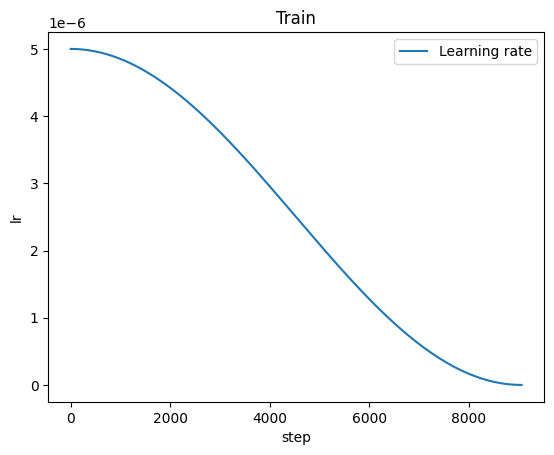

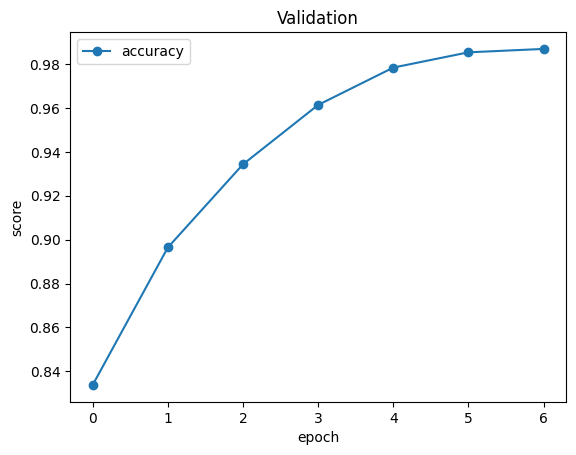

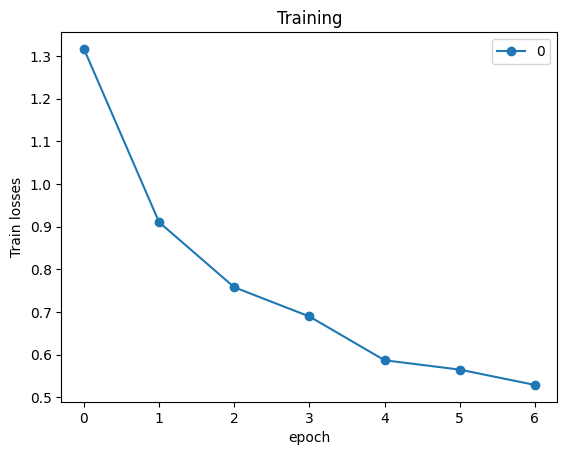

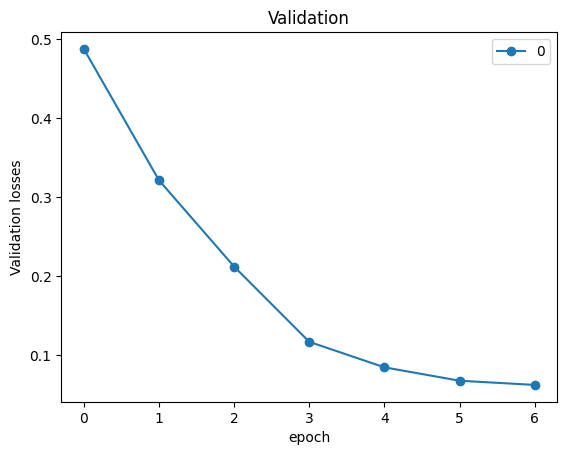

In [6]:
# Save model weights
torch.save(model.state_dict(), 'model_weights.pth')

# Plot Learning Rates
pd.DataFrame({"Learning rate":lr_rates}).plot(xlabel="step", ylabel="lr", style="-", title="Train")

# Plot Validation Metrics
pd.DataFrame(scores).plot(xlabel="epoch", ylabel="score", style="o-", title="Validation")

pd.DataFrame(losses).plot(xlabel="epoch", ylabel="Train losses", style="o-", title="Training")
pd.DataFrame(val_losses).plot(xlabel="epoch", ylabel="Validation losses", style="o-", title="Validation")

# Show validation metrics
val_scores_df = pd.DataFrame(scores)
val_scores_df.index.name = "epoch"
val_scores_df

In [7]:
import gc
del model, train_ds, train_dl, val_ds, val_dl
gc.collect()
torch.cuda.empty_cache()

# To make the inference on all test data, I had to split test dataset into chunks,
# and evaluate them separately (problem with size of RAM)
def split_dataframe(df, chunk_size):
    return [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

test_df = pd.read_csv("/kaggle/input/nie-pdl-24-final-competition/test.csv")
print(len(test_df))
chunk_size = 250
test_chunks = split_dataframe(test_df, chunk_size)

loaded_model = CustomModel(backbone, model_type="vit")
loaded_model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
loaded_model.eval()

loaded_model.to("cuda")
preds = []

for i, chunk in enumerate(test_chunks):
    print(f"Processing chunk {i + 1}/{len(test_chunks)}")
    
    test_ds = CustomDataset(chunk, "/kaggle/input/nie-pdl-24-final-competition/images", transforms, train=False)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    chunk_preds = predict(loaded_model, test_dl, "cuda")
    preds.extend(chunk_preds)
    
    del test_ds, test_dl, chunk_preds
    gc.collect()
    torch.cuda.empty_cache()

2000
Processing chunk 1/8


TTA_Inference: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Processing chunk 2/8


TTA_Inference: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Processing chunk 3/8


TTA_Inference: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Processing chunk 4/8


TTA_Inference: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Processing chunk 5/8


TTA_Inference: 100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


Processing chunk 6/8


TTA_Inference: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]


Processing chunk 7/8


TTA_Inference: 100%|██████████| 50/50 [02:27<00:00,  2.95s/it]


Processing chunk 8/8


TTA_Inference: 100%|██████████| 50/50 [02:27<00:00,  2.95s/it]


In [8]:
assert len(preds) == test_df.shape[0]
print(best_accuracy)
sub = pd.DataFrame({"image_id": test_df["image_id"].values, "label": [reverse_label_mapping[prediction] for prediction in preds]})
filename = f"sub_{best_accuracy}.csv"
sub.to_csv(filename, index=False)
sub.head()

0.9868624420401855


,image_id,label
0,6188.png,Rembrandt-Harmenszoon-van-Rijn
1,4895.png,Pablo-Picasso
2,7716.png,Vincent-van-Gogh
3,4180.png,Claude-Monet
4,5261.png,Andy-Warhol
